# Actor Critic
In this tutorial we solve grid worls using ActorCritic algorithm.

## Environment
We first setup out RL environment and import relevany libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch as th
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
%matplotlib inline

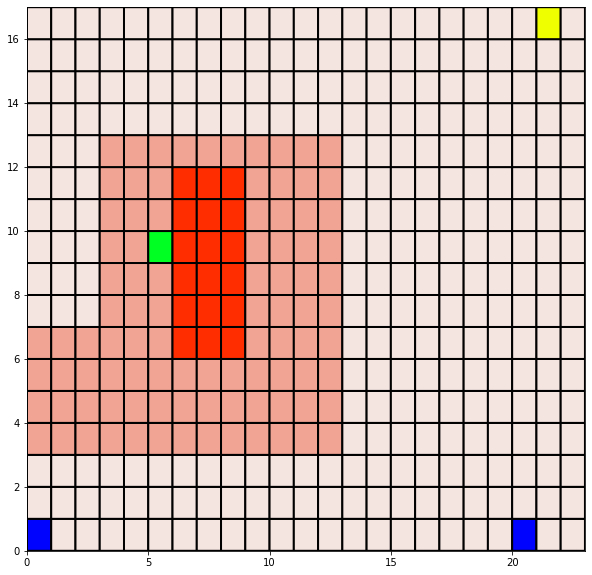

In [2]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]
use_cuda = True
device = th.device("cuda") if use_cuda and th.cuda.is_available() else th.device("cpu")

GAMMA = 0.9
LR=0.001

world = "grid_world2.txt"
goal_reward = 100
start_states = [(0, 0), (0, 20), (16, 21)]
goal_states = [(9, 5)]
max_steps = 10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldWindyEnv(
    world,
    goal_reward=goal_reward,
    start_states=start_states,
    goal_states=goal_states,
    max_steps=max_steps,
    action_fail_prob=0.2,
)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

The environment is same as used in TD learning tutorial.
One change is that we use a 2D grid to denote state as:
- (0,1,2) -> normal grid coordinates with relevant rewards
- 3 -> start states
- 4 -> goal state
- 5 -> current position

In [3]:
def coords_to_grid(state):
    grid = env.coord_to_grid(*state)
    state = th.FloatTensor(grid).unsqueeze(0).unsqueeze(0).to(device)
    return state
print(coords_to_grid(env.state))

tensor([[[[3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 3., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0.,
 

## Actor Critic Network
The AC algorithm need actor network for encoding policy $\pi(a|s)$ and critic network learns the q values $Q(s,a)$.

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)


class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.encode_net = nn.Sequential(
            nn.Conv2d(1, 4, 3),
            nn.ReLU(),
            nn.Conv2d(4, 5, 3),
            nn.ReLU(),
            nn.MaxPool2d(3),
            Flatten(),
        )
        self.actor_net = nn.Sequential(
            nn.Linear(120, 100),
            nn.ReLU(),
            nn.Linear(100, 4),
            nn.Softmax(dim=-1)
        )
        self.critic_net = nn.Sequential(
            nn.Linear(120, 100),
            nn.ReLU(),
            nn.Linear(100, 4)
        )
    
    def critic_forward(self, state):
        x = self.encode_net(state)
        return self.critic_net(x)
    
    def actor_forward(self, state):
        x = self.encode_net(state)
        return self.actor_net(x)
    
    def forward(self, state):
        x = self.encode_net(state)
        return self.actor_net(x), self.critic_net(x)
    
    def sample_action(self, state):
        probs = self.actor_forward(state).squeeze()
        dist = Categorical(probs)
        return dist.sample()

We recall the update equation:

We use TD error to update the critic parameters

$\delta_t = r_t + Q_{w}(s_{t+1}, a_{t+1}) - Q_{w}(s_{t}, a_{t})$

$w \leftarrow w + \alpha \delta_t\nabla_wQ_{w}(s_t, a_t)$

The policy parameter updates is given by

$\theta \leftarrow \theta + \alpha Q_{w}(s_{t}, a_{t})\nabla_{\theta}\ln (\pi_{\theta}(a_t| s_t))$

In [5]:
def update_ac(net: ActorCritic, opt:optim.Adam, s1, a, r, s2, a2):
    prob1, q1 = net(s1)
    q1 = q1[th.arange(q1.size(0)), a]
    prob1 = prob1[th.arange(prob1.size(0)), a]
    q2 = net.critic_forward(s2)
    q2 = q2[th.arange(q2.size(0)), a2].detach()
    td_error = (r + GAMMA*q2 - q1).pow(2).squeeze().mean()
    actor_loss = (-th.log(prob1) * q1.detach()).squeeze().mean()
    print(f"Actor Loss: {actor_loss}, Critic Loss: {td_error}")
    loss = td_error + actor_loss
    opt.zero_grad()
    loss.backward()
    opt.step()

    writer.add_scalar("Actor_loss", actor_loss, ct)
    writer.add_scalar("Critic_loss", td_error, ct)

Finally lets train!

In [6]:
%load_ext tensorboard
%tensorboard --logdir log_dir
EXPTS = 1
EPISODES=10000
PRINT_EVERY = 100

REWARDS, STEPS = [], []
for e in range(EXPTS):
    print(f" Experiment {e+1}")
    rewards = []
    steps = []
    ct = 0
    writer = SummaryWriter(f"log_dir/exp{e+1}", flush_secs=30)
    network = ActorCritic().to(device)

    opt = optim.Adam(network.parameters(), lr=LR)

    for ep in range(EPISODES):
        tot_r, tot_s = 0, 0
        print(f"Episode {ep+1}")
        buffer = [[],[],[],[],[]]
        done = False
        env.reset()
        network.eval()
        with th.no_grad():
            s1 = coords_to_grid(env.state)
            action = int(network.sample_action(s1).unsqueeze(0).detach().cpu().numpy())
            while not done:
                
                buffer[0].append(s1.clone())
                buffer[1].append(action)
                s1, r, done = env.step(action)
                tot_r += r
                tot_s += 1
                steps
                s1 = coords_to_grid(s1)
                buffer[2].append([r])
                buffer[3].append(s1)
                if not done:
                    action = int(network.sample_action(s1).unsqueeze(0).detach().cpu().numpy())
                else:
                    action = UP
                buffer[4].append(action)
            
            buffer[0] = th.cat(buffer[0], 0).to(device)
            buffer[2] = th.FloatTensor(buffer[2]).to(device)
            buffer[3] = th.cat(buffer[3], 0).to(device)
        network.train()
        update_ac(network, opt, buffer[0], buffer[1], buffer[2], buffer[3], buffer[4])
        rewards.append(tot_r)
        steps.append(tot_s)
        print(f"Reward: {tot_r}, Steps: {tot_s}")
        writer.add_scalar("Reward", tot_r, ct)
        writer.add_scalar("Steps", tot_s, ct)
        ct+=1
    REWARDS.append(rewards)
    STEPS.append(steps)
    writer.close()

Reusing TensorBoard on port 6006 (pid 14630), started 1:33:37 ago. (Use '!kill 14630' to kill it.)

 Experiment 1
Episode 1
Actor Loss: 0.007784310728311539, Critic Loss: 6.408914566040039
Reward: -466, Steps: 1715
Episode 2
Actor Loss: -0.07062096148729324, Critic Loss: 2.9504151344299316
Reward: -871, Steps: 3890
Episode 3
Actor Loss: -0.13893654942512512, Critic Loss: 2.849993944168091
Reward: -1009, Steps: 4129
Episode 4
Actor Loss: -0.20523777604103088, Critic Loss: 3.4185941219329834
Reward: -657, Steps: 3272
Episode 5
Actor Loss: -0.26876163482666016, Critic Loss: 5.015333652496338
Reward: -388, Steps: 2131
Episode 6
Actor Loss: -0.32975098490715027, Critic Loss: 3.9918320178985596
Reward: -69, Steps: 2586
Episode 7
Actor Loss: -0.39069250226020813, Critic Loss: 4.83366584777832
Reward: -192, Steps: 2170
Episode 8
Actor Loss: -0.4647614061832428, Critic Loss: 7.563902378082275
Reward: -83, Steps: 1361
Episode 9
Actor Loss: -0.5227586030960083, Critic Loss: 16.65043830871582
Reward: 43, Steps: 606
Episode 10
Actor Loss: -0.5542802214622498, Critic Loss: 4.460060119628906
Reward

KeyboardInterrupt: 